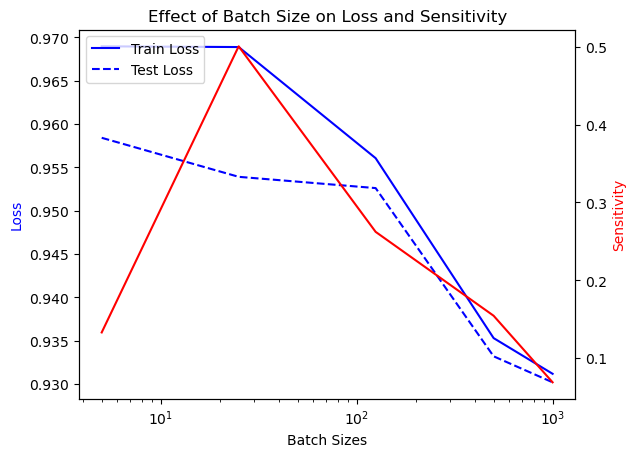

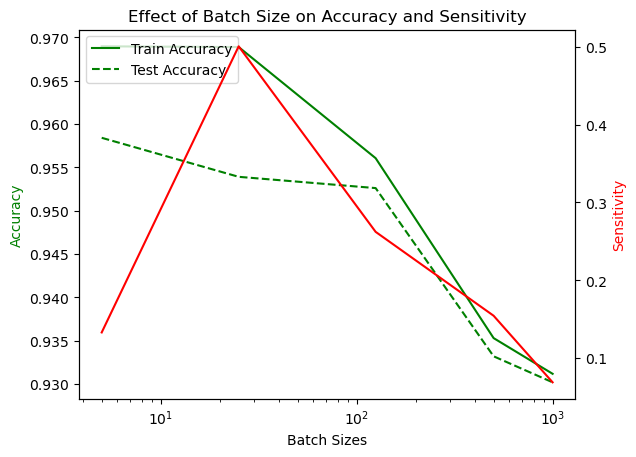

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Data Loading
transform = transforms.ToTensor()
train_data_set = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)
test_data_set = datasets.MNIST(root='./mnist_data', train=False, download=True, transform=transform)

# Different batch sizes for multiple models
batch_sizes = [5, 25, 125, 500, 1000]
train_loader1 = DataLoader(train_data_set, batch_size=batch_sizes[0], shuffle=True)
test_loader1 = DataLoader(test_data_set, batch_size=batch_sizes[0], shuffle=True)

train_loader2 = DataLoader(train_data_set, batch_size=batch_sizes[1], shuffle=True)
test_loader2 = DataLoader(test_data_set, batch_size=batch_sizes[1], shuffle=True)

train_loader3 = DataLoader(train_data_set, batch_size=batch_sizes[2], shuffle=True)
test_loader3 = DataLoader(test_data_set, batch_size=batch_sizes[2], shuffle=True)

train_loader4 = DataLoader(train_data_set, batch_size=batch_sizes[3], shuffle=True)
test_loader4 = DataLoader(test_data_set, batch_size=batch_sizes[3], shuffle=True)

train_loader5 = DataLoader(train_data_set, batch_size=batch_sizes[4], shuffle=True)
test_loader5 = DataLoader(test_data_set, batch_size=batch_sizes[4], shuffle=True)

# Function to calculate model parameters
def CalcParams(model):
    return sum(params.numel() for params in model.parameters() if params.requires_grad)

# Model Definition (common for all)
class Model(nn.Module):
    def __init__(self, in_features=784, h1=20, h2=20, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)    
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

# Initialize Models
model1 = Model()
model2 = Model()
model3 = Model()
model4 = Model()
model5 = Model()

# Define optimizer, loss function, epochs
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.001)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

# Helper function for training and testing models
def train_test_model(model, optimizer, train_loader, test_loader):
    train_correct = []
    test_correct = []
    for i in range(epochs):
        train_corr = 0
        test_corr = 0
        for b, (X_train, y_train) in enumerate(train_loader):
            y_pred = model(X_train.view(X_train.size(0), -1))
            loss = criterion(y_pred, y_train)
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            train_corr += batch_corr
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_correct.append(train_corr)
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_loader):
                y_val = model(X_test.view(X_test.size(0), -1))
                predicted = torch.max(y_val.data, 1)[1]
                test_corr += (predicted == y_test).sum()
        test_correct.append(test_corr)
    return train_correct, test_correct

# Sensitivity Calculation
def calculate_sensitivity(model):
    frob_norm_all = 0
    counter = 0
    for p in model.parameters():
        if p.grad is not None:
            frob_norm = torch.linalg.norm(p.grad).item()
            frob_norm_all += frob_norm
            counter += 1
    return frob_norm_all / counter if counter > 0 else 0

# Train models and collect performance metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
sensitivity_list = []

for model, optimizer, train_loader, test_loader in zip([model1, model2, model3, model4, model5],
                                                       [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5],
                                                       [train_loader1, train_loader2, train_loader3, train_loader4, train_loader5],
                                                       [test_loader1, test_loader2, test_loader3, test_loader4, test_loader5]):
    train_corr, test_corr = train_test_model(model, optimizer, train_loader, test_loader)
    train_losses.append(float(train_corr[-1]) / len(train_data_set))
    test_losses.append(float(test_corr[-1]) / len(test_data_set))
    train_accuracies.append(float(train_corr[-1]) / len(train_data_set))
    test_accuracies.append(float(test_corr[-1]) / len(test_data_set))
    sensitivity_list.append(calculate_sensitivity(model))

# Visualization for Loss and Sensitivity
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(batch_sizes, train_losses, 'b-', label='Train Loss')
ax1.plot(batch_sizes, test_losses, 'b--', label='Test Loss')
ax2.plot(batch_sizes, sensitivity_list, 'r-', label='Sensitivity')
ax1.set_title('Effect of Batch Size on Loss and Sensitivity')
ax1.set_xlabel('Batch Sizes')
ax1.set_xscale('log')
ax1.set_ylabel('Loss', color='b')
ax2.set_ylabel('Sensitivity', color='r')
ax1.legend(loc='upper left')
plt.show()

# Visualization for Accuracy and Sensitivity
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(batch_sizes, train_accuracies, 'g-', label='Train Accuracy')
ax1.plot(batch_sizes, test_accuracies, 'g--', label='Test Accuracy')
ax2.plot(batch_sizes, sensitivity_list, 'r-', label='Sensitivity')
ax1.set_title('Effect of Batch Size on Accuracy and Sensitivity')
ax1.set_xlabel('Batch Sizes')
ax1.set_xscale('log')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Sensitivity', color='r')
ax1.legend(loc='upper left')
plt.show()
